# prep work for a little demo

Scenario: find a set of diaObjects that all are peaking around the same time.

## set up

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
from lsst.rsp import get_tap_service

from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
import astropy.units as u

In [2]:
service = get_tap_service("tap")

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [4]:
plt.style.use('tableau-colorblind10')

plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

## identify potential SNIa to use

Use the same method for identifying potential SNIa as in NB 07a.

In [5]:
redshift_min = 0.1
redshift_max = 0.3

snia_peak_mag = -19.0
snia_peak_mag_range = 0.5

snia_peak_mr_min = cosmo.distmod(redshift_min).value + snia_peak_mag - snia_peak_mag_range
snia_peak_mr_max = cosmo.distmod(redshift_max).value + snia_peak_mag + snia_peak_mag_range

snia_peak_mg_max = 24.0
snia_peak_mi_max = 24.0

snia_ampl_mr_min = 1.5
snia_ampl_mr_max = 5.5

snia_nDiaSources_min = 15
snia_nDiaSources_max = 100

snia_duration_min = 50
snia_duration_max = 300

Search for `diaObjects` that have suitable light curve summary parameters to potentially be SNIa.

In [6]:
DiaObjs = service.search("SELECT TOP 10000 "
                         "ra, decl, diaObjectId, nDiaSources, "
                         "scisql_nanojanskyToAbMag(rPSFluxMin) AS rMagMax, "
                         "scisql_nanojanskyToAbMag(rPSFluxMax) AS rMagMin, "
                         "scisql_nanojanskyToAbMag(gPSFluxMax) AS gMagMin, "
                         "scisql_nanojanskyToAbMag(iPSFluxMax) AS iMagMin "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE nDiaSources > "+str(snia_nDiaSources_min)+" "
                         "AND nDiaSources < "+str(snia_nDiaSources_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMax) > "+str(snia_peak_mr_min)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMax) < "+str(snia_peak_mr_max)+" "
                         "AND scisql_nanojanskyToAbMag(gPSFluxMax) < "+str(snia_peak_mg_max)+" "
                         "AND scisql_nanojanskyToAbMag(iPSFluxMax) < "+str(snia_peak_mi_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) < "+str(snia_ampl_mr_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) > "+str(snia_ampl_mr_min)+" ").to_table()

In [7]:
DiaObjs['rMagAmp'] = DiaObjs['rMagMax'] - DiaObjs['rMagMin']

In [8]:
temp = np.unique(np.asarray(DiaObjs['diaObjectId'][0:-1]))
print(len(temp))
tempstring = "(" + ','.join(['%22i' % num for num in temp]) + ")"
# tempstring

6569


Get the light curves from `DiaSource` so that duration and date of r-band maximum can be determined.

In [9]:
DiaSrcs = service.search("SELECT diao.diaObjectId, dias.midPointTai, dias.filterName, "
                         "scisql_nanojanskyToAbMag(dias.psFlux) AS psAbMag "
                         "FROM dp02_dc2_catalogs.DiaObject AS diao "
                         "JOIN dp02_dc2_catalogs.DiaSource AS dias "
                         "ON diao.diaObjectId = dias.diaObjectId "
                         "WHERE diao.diaObjectId IN "+tempstring).to_table()

In [10]:
DiaObjs['duration'] = np.zeros(len(DiaObjs), dtype='float')
DiaObjs['mjd_rMagMin'] = np.zeros(len(DiaObjs), dtype='float')
DiaObjs['nDiaSrcs'] = np.zeros(len(DiaObjs), dtype='int')
DiaObjs['nrDiaSrcs'] = np.zeros(len(DiaObjs), dtype='int')
DiaObjs['nppDiaSrcs'] = np.zeros(len(DiaObjs), dtype='float')

for i, tid in enumerate(temp):
    # index the diaObject for this element in temp
    ix = np.where(DiaObjs['diaObjectId'] == tid)[0]
    # index the diaSources for this diaObject
    tx = np.where(DiaSrcs['diaObjectId'] == tid)[0]
    DiaObjs['nDiaSrcs'][ix] = len(tx)
    DiaObjs['duration'][ix] = np.max(DiaSrcs['midPointTai'][tx]) - np.min(DiaSrcs['midPointTai'][tx])
    # index the r-band diaSources for this diaObject
    trx = np.where((DiaSrcs['diaObjectId'] == tid) & (DiaSrcs['filterName'] == 'r'))[0]
    DiaObjs['nrDiaSrcs'][ix] = len(trx)
    mx = np.argmin(DiaSrcs['psAbMag'][trx])
    DiaObjs['mjd_rMagMin'][ix] = DiaSrcs['midPointTai'][trx[mx]]
    # index the pre-"peak" diaSources for this diaObject
    tpx = np.where(DiaSrcs['midPointTai'][tx] <= DiaObjs['mjd_rMagMin'][i])[0]
    DiaObjs['nppDiaSrcs'][ix] = len(tpx)
    del ix, tx, trx, mx, tpx

In [11]:
DiaObjs

ra,decl,diaObjectId,nDiaSources,rMagMax,rMagMin,gMagMin,iMagMin,rMagAmp,duration,mjd_rMagMin,nDiaSrcs,nrDiaSrcs,nppDiaSrcs
deg,deg,,,,,,,,,,,,
float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64
49.7910763,-44.5121505,1248684569339625641,59,22.902667056495986,20.625767646123265,19.856498968250772,18.918260610837965,2.276899410372721,1559.7958579999977,60701.0943082,59,2,0.0
50.0366345,-44.6033099,1248684569339626125,70,23.642439968675003,21.544689534977653,23.143955657199157,22.67237339606578,2.0977504336973496,1171.8551970000044,61318.2902602,70,24,25.0
50.1807874,-44.6535504,1248675773246604126,43,22.36280480327831,20.351726129016583,23.61547483152016,23.4619567849103,2.011078674261725,700.933772999997,61373.2278372,43,17,0.0
54.8620173,-44.6481827,1249520198176736045,80,22.743170493554125,19.98012253021932,22.286429405521005,21.837460267502763,2.763047963334806,681.9322509999984,60960.2252922,80,22,0.0
55.148125,-44.629532,1249511402083713389,79,23.637481876812412,21.20822647554448,23.106177809864455,21.986948876384943,2.429255401267934,1149.968845000003,60945.1923242,79,34,0.0
61.3055212,-44.4875329,1250804427757977660,20,21.659034161863417,19.629902659141354,18.206524961212963,16.98841713736357,2.0291315027220627,1736.154588999998,59929.1459222,20,2,0.0
61.3835053,-44.5735339,1250804427757978326,88,23.364667629460776,21.680602578717057,23.136989015724993,22.672848101633356,1.684065050743719,1189.7597070000047,60998.1706512,88,35,0.0
53.9767924,-44.630488,1249546586455802795,75,23.730635551727815,20.917439153914685,22.778565831779986,22.219189094071247,2.8131963978131296,716.9955429999973,60998.1526922,75,30,0.0


In [12]:
tx = np.where((DiaObjs['duration'] > snia_duration_min)
              & (DiaObjs['duration'] < snia_duration_max))[0]
print(len(tx))

331


OK so in total there are 331 SNIa that pass these crude cuts for low-z SNIa.

Which dates might have many SNIa peaking?

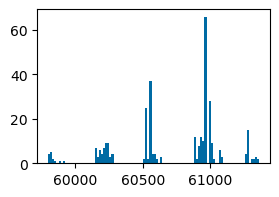

In [13]:
fig = plt.figure(figsize=(3, 2))
plt.hist(DiaObjs['mjd_rMagMin'][tx], bins=100)
plt.show()

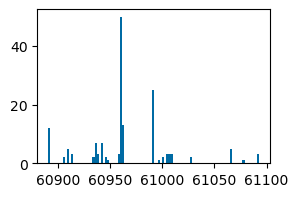

In [14]:
fig = plt.figure(figsize=(3, 2))
ttx = np.where((DiaObjs['mjd_rMagMin'][tx] > 60800) & (DiaObjs['mjd_rMagMin'][tx] < 61100))[0]
plt.hist(DiaObjs['mjd_rMagMin'][tx[ttx]], bins=100)
plt.show()
del ttx

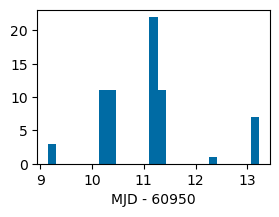

In [15]:
fig = plt.figure(figsize=(3, 2))
ttx = np.where((DiaObjs['mjd_rMagMin'][tx] > 60950) & (DiaObjs['mjd_rMagMin'][tx] < 60975))[0]
plt.hist(DiaObjs['mjd_rMagMin'][tx[ttx]]-60950, bins=25)
plt.xlabel('MJD - 60950')
plt.show()
del ttx

In [16]:
ttx = np.where((DiaObjs['mjd_rMagMin'][tx] > 60960) & (DiaObjs['mjd_rMagMin'][tx] < 60962))[0]
print(len(ttx))

55


OK how many of these have a lot of pre-peak light curve detections.

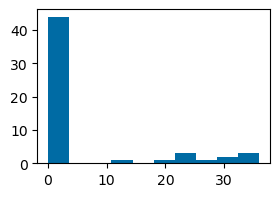

In [17]:
fig = plt.figure(figsize=(3, 2))
plt.hist(DiaObjs['nppDiaSrcs'][tx[ttx]])
plt.show()

Distribution of durations.

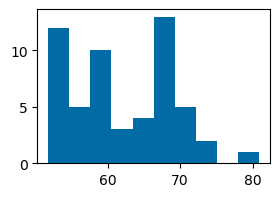

In [18]:
fig = plt.figure(figsize=(3, 2))
plt.hist(DiaObjs['duration'][tx[ttx]])
plt.show()

And what are their brightest r-band detections.

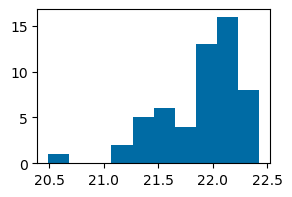

In [19]:
fig = plt.figure(figsize=(3, 2))
plt.hist(DiaObjs['rMagMin'][tx[ttx]])
plt.show()

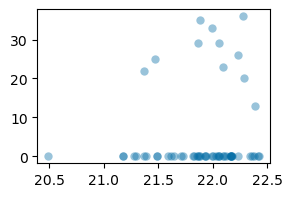

In [20]:
fig = plt.figure(figsize=(3, 2))
plt.plot(DiaObjs['rMagMin'][tx[ttx]], DiaObjs['nppDiaSrcs'][tx[ttx]], 'o', alpha=0.4, mew=0)
plt.show()

In [21]:
tttx = np.where((DiaObjs['nppDiaSrcs'][tx[ttx]] >= 5)
               & (DiaObjs['rMagMin'][tx[ttx]] >= 20)
               & (DiaObjs['rMagMin'][tx[ttx]] <= 22))[0]
print(len(tttx))

5


Store the `diaObjectId` of our 31 objects of interest.

In [22]:
my_list = np.asarray(DiaObjs['diaObjectId'][tx[ttx[tttx]]], dtype='int')
my_list

array([1568026726510894110, 1569909090417642499, 1653700672547196623,
       1734140943235288573, 1825796232526695593])

In [23]:
my_list_string = "(" + ','.join(['%22i' % num for num in my_list]) + ")"
my_list_string

'(   1568026726510894110,   1569909090417642499,   1653700672547196623,   1734140943235288573,   1825796232526695593)'

In [24]:
del tx, ttx, tttx

## which potential SNIa are the best to use for the demo?

Want objects that have demonstrated a rise, and have a bunch of pre-peak light curve detections.

 0  0  0  1568026726510894110 58.9   35 
 1  0  1  1569909090417642499 57.7   29 
 2  1  0  1653700672547196623 81.0   33 
 3  1  1  1734140943235288573 70.9   25 
 4  2  0  1825796232526695593 67.9   34 


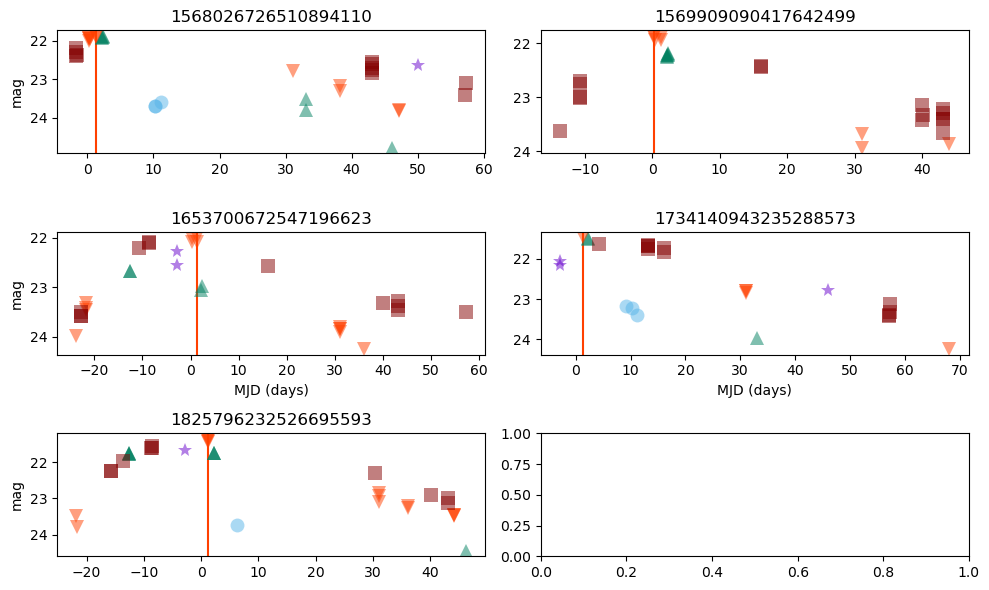

In [39]:
fig, ax = plt.subplots(3, 2, figsize=(10, 6), sharey=False, sharex=False)

x = 0

for i in range(3):
    for j in range(2):
        if x < len(my_list):
            ix = np.where(DiaObjs['diaObjectId'] == my_list[x])[0]
            tx = np.where(DiaSrcs['diaObjectId'] == my_list[x])[0]
            print('%2i %2i %2i %20i %4.1f %4i ' 
                  % (x, i, j, my_list[x], DiaObjs['duration'][ix], len(tx)))
            ax[i, j].axvline(DiaObjs['mjd_rMagMin'][ix] - 60960, color=plot_filter_colors['r'])
            for f, filt in enumerate(plot_filter_labels):
                fx = np.where(DiaSrcs['filterName'][tx] == filt)[0]
                ax[i, j].plot(DiaSrcs['midPointTai'][tx[fx]] - 60960, 
                              DiaSrcs['psAbMag'][tx[fx]],
                              plot_filter_symbols[filt], ms=10, mew=0, alpha=0.5,
                              color=plot_filter_colors[filt])
                del fx
            del ix, tx
            
            ax[i, j].invert_yaxis()
            ax[i, j].set_title(my_list[x])
            if i == 1:
                ax[i, j].xaxis.set_label_text('MJD (days)')
            if j == 0:
                ax[i, j].yaxis.set_label_text('mag')
        x += 1

plt.tight_layout()
plt.show()

OK so these will be the five that the brokers "find" and that we need to retrieve host info for.

## what is their host situation

first make sure there are at least some nearby things to check out

In [41]:
for i, tid in enumerate(my_list):
    ix = np.where(DiaObjs['diaObjectId'] == tid)[0]

    fra = float(DiaObjs['ra'][ix])
    fdec = float(DiaObjs['decl'][ix])
    sra = str(fra)
    sdec = str(fdec)
    srad = str(np.round(20.0 / 3600.0, 5))
    print(i, tid, sra, sdec, srad)

    query = "SELECT objectId, coord_ra, coord_dec, x, y, refExtendedness, "\
    "shape_xx, shape_xy, shape_yy, r_kronRad, i_kronRad "\
    "FROM dp02_dc2_catalogs.Object "\
    "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
    "CIRCLE('ICRS', "+sra+", "+sdec+", "+srad+")) = 1 "\
    "AND detect_isPrimary = 1 "
    Objs = service.search(query).to_table()
    print('number of Objects within 20" = ', len(Objs))
    
    sncoord = SkyCoord(fra, fdec, unit='deg')
    tra = np.asarray(Objs['coord_ra'], dtype='float')
    tdec = np.asarray(Objs['coord_dec'], dtype='float')
    objcoords = SkyCoord(tra, tdec, unit='deg')
    separations = objcoords.separation(sncoord)
    
    sx = np.where(Objs['refExtendedness'] == 0)[0]
    gx = np.where(Objs['refExtendedness'] == 1)[0]
    print('number of point: ', len(sx), '   extended: ', len(gx))

    ssx = np.argsort(separations[sx])
    print('three nearest stars: ')
    for j in range(3):
        print(Objs['objectId'][sx[ssx[j]]], np.round(separations[sx[ssx[j]]].arcsec, 2))
    
    sgx = np.argsort(separations[gx])
    print('three nearest galaxies: ')
    for j in range(3):
        print(Objs['objectId'][gx[sgx[j]]], np.round(separations[gx[sgx[j]]].arcsec, 2))


0 1568026726510894110 63.6025914 -38.634654 0.00556
number of Objects within 20" =  51
number of point:  11    extended:  40
three nearest stars: 
1568026726510919263 0.03
1568026726510919265 4.45
1568026726510919393 8.53
three nearest galaxies: 
1568026726510919266 3.15
1568026726510919261 4.62
1568026726510919497 5.08
1 1569909090417642499 69.9257038 -38.1424959 0.00556
number of Objects within 20" =  49
number of point:  7    extended:  42
three nearest stars: 
1569425305301455018 6.47
1569425305301455016 8.15
1569425305301455020 8.62
three nearest galaxies: 
1569425305301455007 0.02
1569425305301455003 3.08
1569425305301455014 3.98
2 1653700672547196623 70.8210894 -35.9915118 0.00556
number of Objects within 20" =  42
number of point:  9    extended:  33
three nearest stars: 
1653700672547231401 9.94
1653700672547231164 11.98
1653700672547231611 12.03
three nearest galaxies: 
1653700672547231391 2.13
1653700672547231402 2.58
1653700672547231397 4.34
3 1734140943235288573 52.5432991

In [30]:
fra = float(DiaObjs['ra'][ix])
fdec = float(DiaObjs['decl'][ix])

In [31]:
px = np.where(Objs['refExtendedness'] == 0)[0]
ex = np.where(Objs['refExtendedness'] == 1)[0]
print('point: ', len(px), '   extended: ', len(ex))

point:  1    extended:  9


In [32]:
sncoord = SkyCoord(fra, fdec, unit='deg')
tra = np.asarray(Objs['coord_ra'], dtype='float')
tdec = np.asarray(Objs['coord_dec'], dtype='float')
objcoords = SkyCoord(tra, tdec, unit='deg')

In [33]:
separations = objcoords.separation(sncoord)

In [36]:
separations.arcsec

array([9.82143996, 8.204319  , 0.02532922, 6.82453907, 7.28050644,
       5.92824527, 9.81128539, 9.48316343, 4.63680243, 6.97706813])